In [1]:
# Libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.


In [2]:
%matplotlib inline

sns.set(style = 'whitegrid', palette= 'muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
# Reading in data from the Kaggle Credit Card Fraud dataset
df = pd.read_csv("data/creditcard.csv")

In [4]:
# Data exploration
df.shape

(284807, 31)

In [5]:
df.isnull().values.any()

False

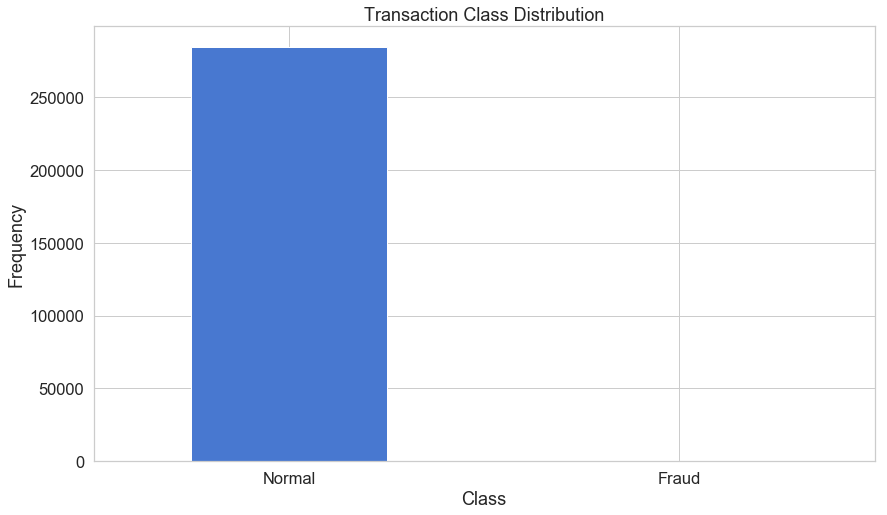

In [7]:
# Checking the data distribution
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [8]:
# Encoding the 2 types of transactions
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [11]:
# Checking the shape of each transaction
print("frauds:", frauds.shape)
print("normal:", normal.shape)

frauds: (492, 31)
normal: (284315, 31)


In [12]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [13]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

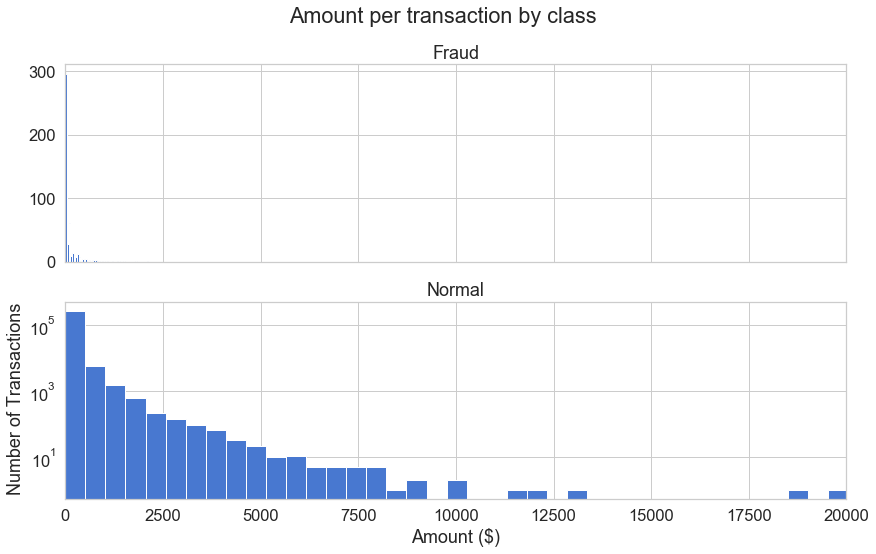

In [19]:
# Graphical Representation
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
f.suptitle('Amount per transaction by class')
bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel(' Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

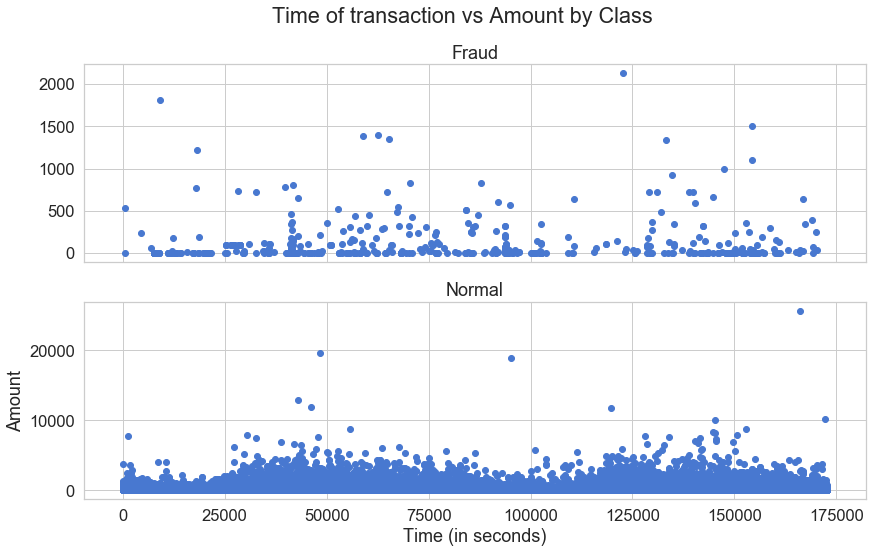

In [20]:
# Checking rates of fraud by seasonality (seconds)
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
f.suptitle('Time of transaction vs Amount by Class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in seconds)')
plt.ylabel('Amount')
plt.show()

In [31]:
class text:
    BOLD = '\033[1m'
    END = '\033[0m'
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'

In [32]:
print(text.BOLD + 'Analysis Results:' + text.END + 'The time of the transaction results seems\n pretty evenly distributed and doesnt seem to be a factor') 

Analysis Results:The time of the transaction results seems
 pretty evenly distributed and doesnt seem to be a factor


In [33]:
# Autoencoder Neural Networks
from sklearn.preprocessing import StandardScaler

In [34]:
# I am removing the time column from the dataset 
data = df.drop(['Time'], axis=1)

#The scaler removes the mean and scales the values to unit variance
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [35]:
# Given the dataset has almost entirely non-fraudulent transactions, I will
# train the model on normal transactions only to make it easier for the model
# to spot anomalies later on.

# Testing model on 20% of data.
X_train, X_test = train_test_split(data, test_size = 0.2, random_state = RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis = 1)

# Testing
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis = 1)

X_train = X_train.values
X_test = X_test.values


In [38]:
# Looking at the shape of the data
X_train.shape

(227451, 29)

In [41]:
# Building the 4-layer autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 14

In [42]:
# Autoencoder Neural Network
input_layer = Input(shape=(input_dim, ))

# Layers 1-2: encoder
# Using L1 regularization
encoder = Dense(encoding_dim, activation = "tanh",
                activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation = "relu")(encoder)

# Layers 3-4: decoder
decoder = Dense(int(encoding_dim / 2), activation = 'tanh')(encoder)
decoder = Dense(input_dim, activation = 'relu')(decoder)

autoencoder = Model(inputs = input_layer, outputs = decoder)

Instructions for updating:
Colocations handled automatically by placer.


In [43]:
# Training model on 100 epochs with 32-sample batch size
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='/media/old-tf-hackers-7/logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Instructions for updating:
Use tf.cast instead.
Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 32s 142us/step - loss: 0.8298 - acc: 0.5865 - val_loss: 0.8126 - val_acc: 0.6376
Epoch 2/100
227451/227451 [==============================] - 31s 136us/step - loss: 0.7613 - acc: 0.6631 - val_loss: 0.7792 - val_acc: 0.6686
Epoch 3/100
227451/227451 [==============================] - 32s 139us/step - loss: 0.7456 - acc: 0.6704 - val_loss: 0.7744 - val_acc: 0.6648
Epoch 4/100
227451/227451 [==============================] - 32s 140us/step - loss: 0.7410 - acc: 0.6703 - val_loss: 0.7703 - val_acc: 0.6692
Epoch 5/100
227451/227451 [==============================] - 33s 147us/step - loss: 0.7375 - acc: 0.6711 - val_loss: 0.7675 - val_acc: 0.6706
Epoch 6/100
227451/227451 [==============================] - 34s 152us/step - loss: 0.7349 - acc: 0.6689 - val_loss: 0.7708 - val_acc: 0.6606
Epoch 7/100
227451/227451 [======================

Epoch 56/100
227451/227451 [==============================] - 28s 122us/step - loss: 0.7242 - acc: 0.6596 - val_loss: 0.7657 - val_acc: 0.6561
Epoch 57/100
227451/227451 [==============================] - 29s 126us/step - loss: 0.7244 - acc: 0.6600 - val_loss: 0.7568 - val_acc: 0.6586
Epoch 58/100
227451/227451 [==============================] - 30s 132us/step - loss: 0.7243 - acc: 0.6590 - val_loss: 0.7594 - val_acc: 0.6558
Epoch 59/100
227451/227451 [==============================] - 31s 135us/step - loss: 0.7247 - acc: 0.6593 - val_loss: 0.7597 - val_acc: 0.6567
Epoch 60/100
227451/227451 [==============================] - 31s 135us/step - loss: 0.7248 - acc: 0.6599 - val_loss: 0.7573 - val_acc: 0.6554
Epoch 61/100
227451/227451 [==============================] - 31s 135us/step - loss: 0.7243 - acc: 0.6595 - val_loss: 0.7568 - val_acc: 0.6607
Epoch 62/100
227451/227451 [==============================] - 31s 135us/step - loss: 0.7241 - acc: 0.6601 - val_loss: 0.7578 - val_acc: 0.6598

In [44]:
autoencoder = load_model('model.h5')

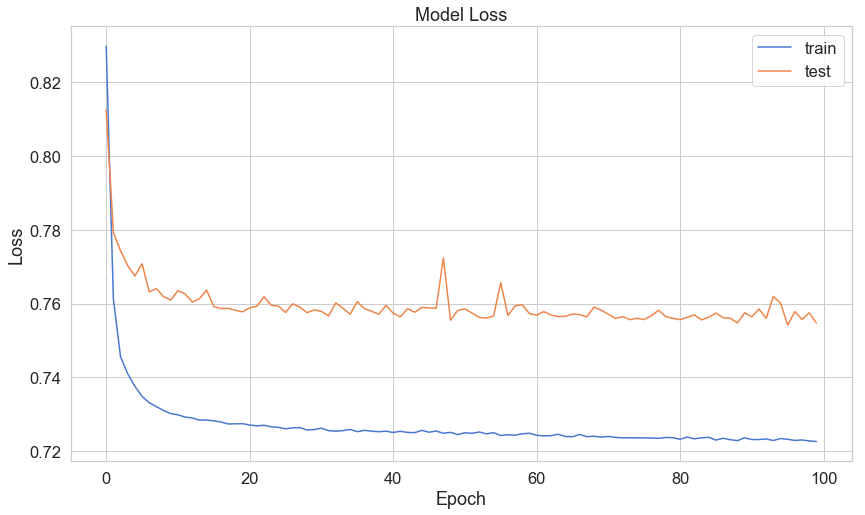

In [45]:
# Evaluating the model
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc = 'upper right');


In [46]:
# Understanding the error distribution
predictions = autoencoder.predict(X_test)

In [50]:
mse = np.mean(np.power(X_test - predictions, 2), axis = 1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [51]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.747800,0.001720
std,3.405316,0.041443
min,0.057692,0.000000
25%,0.248889,0.000000
50%,0.413118,0.000000
75%,0.652991,0.000000
max,261.985856,1.000000


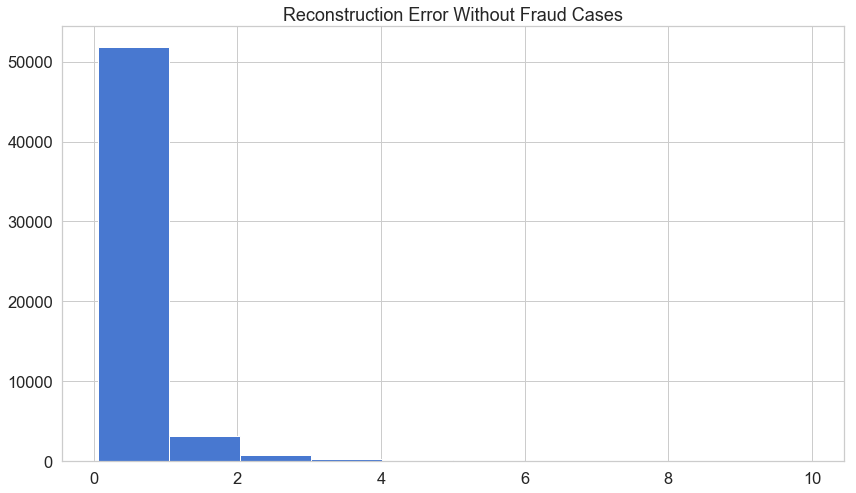

In [61]:
# Looking at the error rate without fraud cases
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title('Reconstruction Error Without Fraud Cases')
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins= 10)

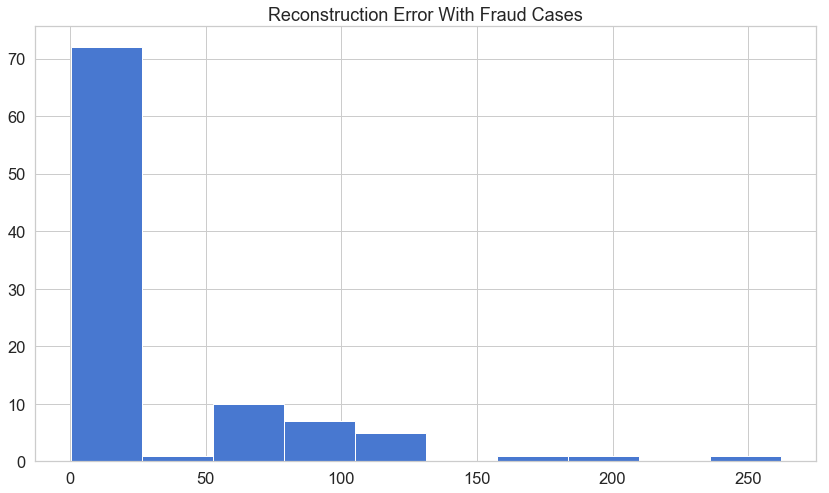

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title('Reconstruction Error With Fraud Cases')
fraud_error_df = error_df[error_df['true_class'] == 1]
_= ax.hist(fraud_error_df.reconstruction_error.values, bins = 10)

In [66]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

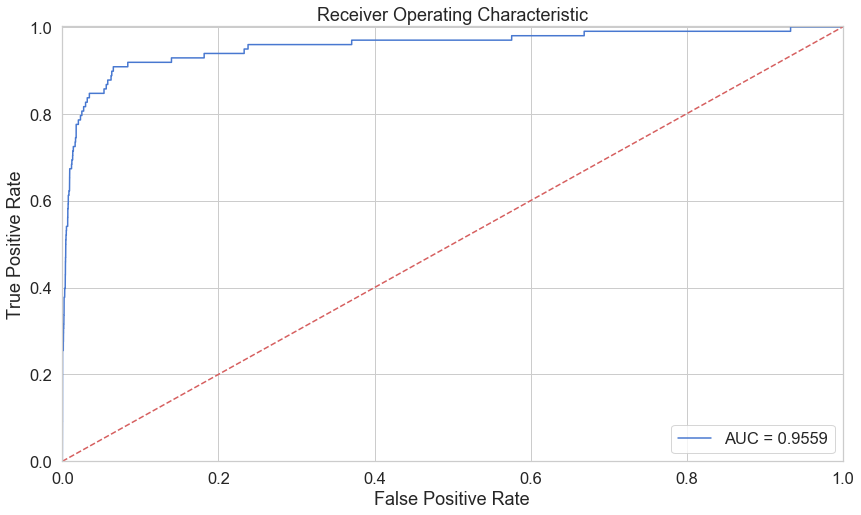

In [67]:
# Using ROC Curve
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

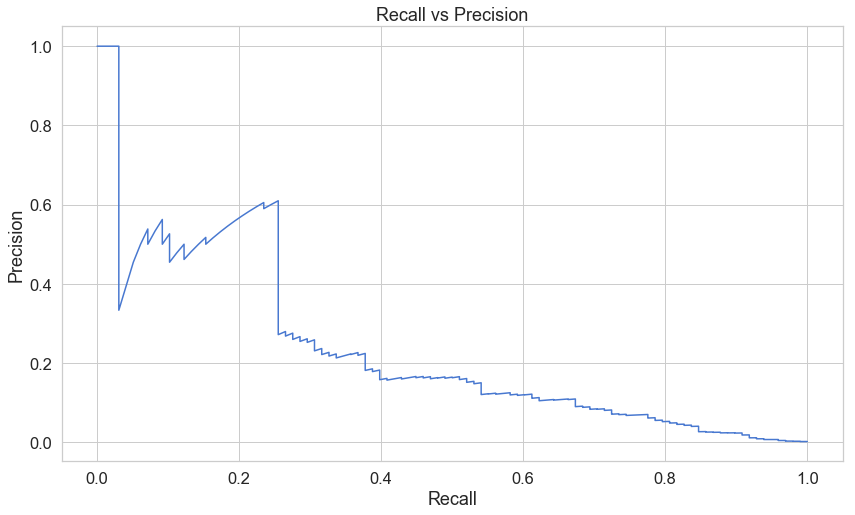

In [68]:
# Recall vs Precision
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

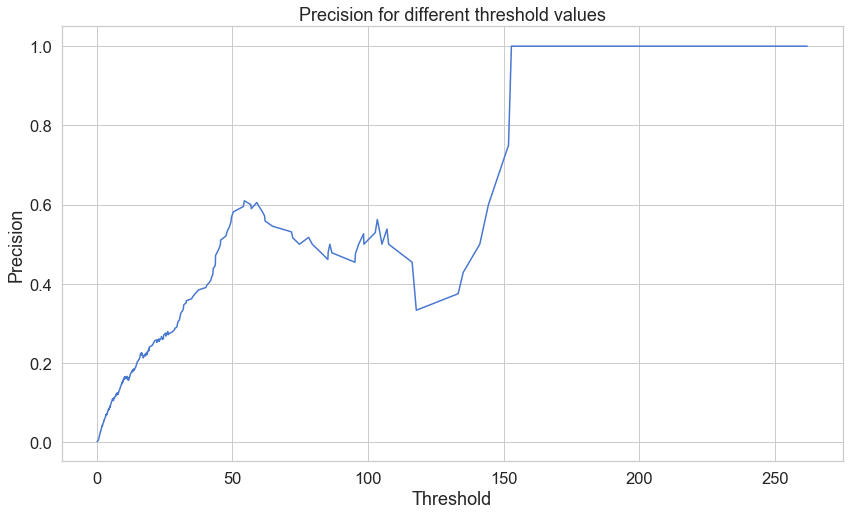

In [69]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

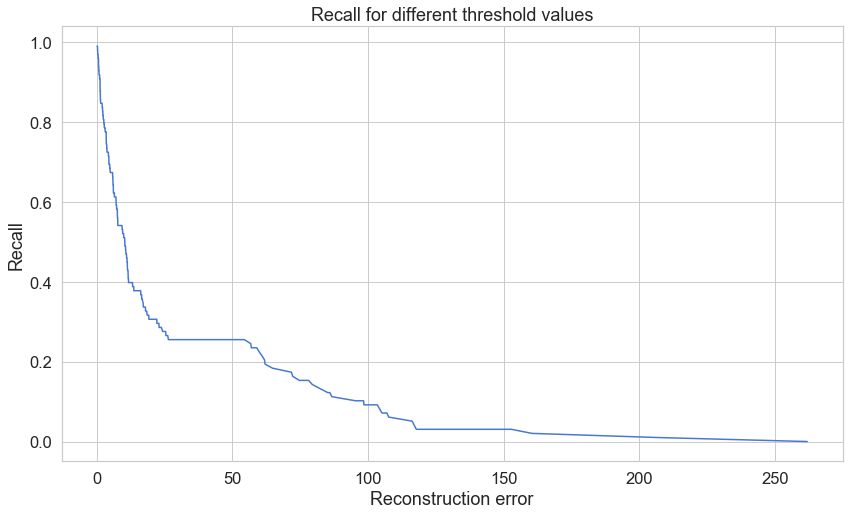

In [70]:
# Looking at Recall
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [92]:
# Determining if a transaction is fraudulent:
# Calc reconstruction error. If error is > threshold , == fraud
threshold = 3.3

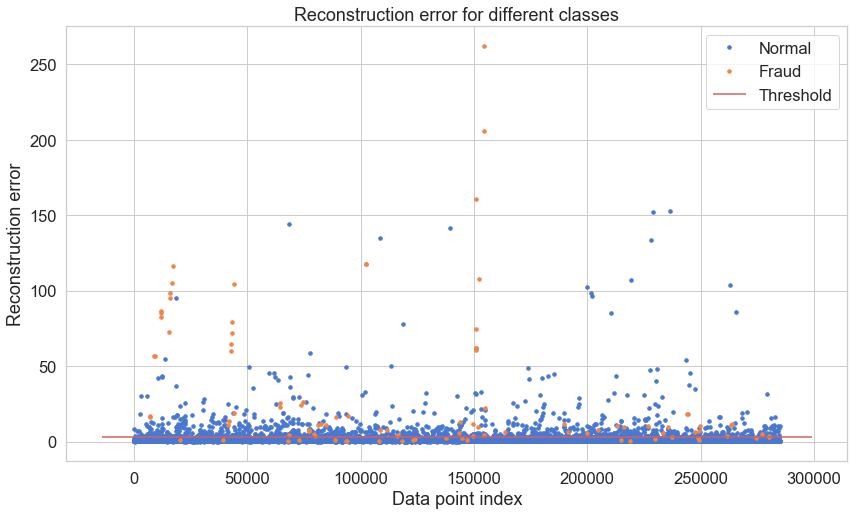

In [93]:
# Visualize the division between transactions
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

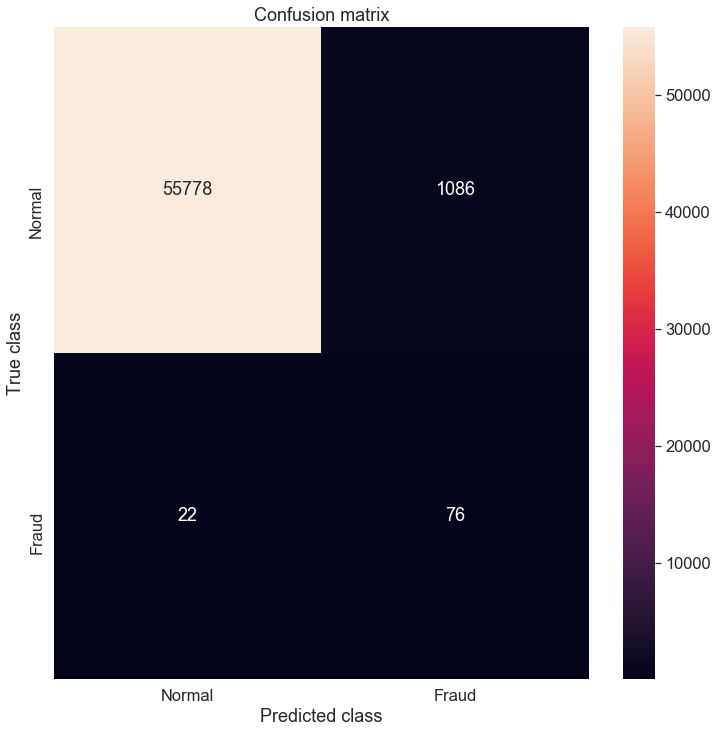

In [94]:
# Use confusion matrix to analyze results
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [77]:
print(text.BOLD + 'Analysis Results:' + text.END + ' While model is efficient at capturing fraud cases, it also\n has a high number of false positives.')

Analysis Results: While model is efficient at capturing fraud cases, it also
 has a high number of false positives.
